In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller


from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn

import tensorflow as tf



from itertools import product

In [2]:
import warnings
import itertools

In [3]:
data_raw = pd.read_csv('./data/USD_CNY_Historical_Data(3).csv')

# filter out holidays. During hoildays, high = low in my source

In [35]:
data_name = 'USD-CNY'
attention_flag = False
train_len = int(len(data_raw)*0.3)
num_epochs = 100

In [36]:
ARIMA_Train = data_raw.loc[:,['Price']][0:train_len]
ARIMA_Test =  data_raw.loc[:,['Price']][train_len:]
ARIMA_Test_Input = data_raw.loc[:,['Date']][train_len:]

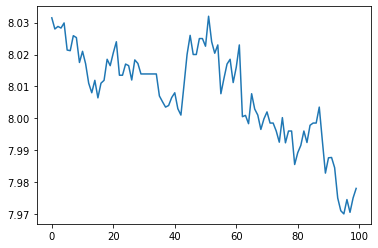

In [37]:
ARIMA_mean_log = np.log(data_raw.loc[:,['Price']])
plt.plot(ARIMA_Train.iloc[:100])

In [38]:
X = ARIMA_Train.values
result = adfuller(X)
d=-1
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1]<=0.05:
    d=0
else:
    for i in range(1,4):
        X=pd.DataFrame(X)
        X=X-X.shift(periods=1)
        X=X.dropna()
        X=np.array(X)
        result = adfuller(X)
        print('d=%f' % i)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[1]<=0.05:
            d=i
            break

ADF Statistic: -2.639315
p-value: 0.085141
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
d=1.000000
ADF Statistic: -13.027012
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [39]:
 warnings.filterwarnings("ignore")
 q_arima = range(0, 3)
 d_arima=d
 p_arima = range(0, 8)
 AIC_arima = []
 ARIMAX_model = []
 pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]

 for pdq in pdqs:
     try:
         mod = ARIMA(ARIMA_Train,order=pdq)

         results = mod.fit()
         print('ARIMAX{} - AIC:{}'.format(pdq, results.aic))
         AIC_arima.append(results.aic)
         ARIMAX_model.append([(1,1,0), pdq])
     except:
             continue

ARIMAX(0, 1, 0) - AIC:-14036.748967431808
ARIMAX(0, 1, 1) - AIC:-14046.27505555295
ARIMAX(0, 1, 2) - AIC:-14047.31474024984
ARIMAX(1, 1, 0) - AIC:-14045.254572811544
ARIMAX(1, 1, 1) - AIC:-14045.967042056142
ARIMAX(2, 1, 0) - AIC:-14047.88395268052
ARIMAX(2, 1, 1) - AIC:-14052.747778737437
ARIMAX(2, 1, 2) - AIC:-14047.505578277414
ARIMAX(3, 1, 0) - AIC:-14046.263059037788
ARIMAX(3, 1, 1) - AIC:-14063.091300550164
ARIMAX(3, 1, 2) - AIC:-14064.955619843106
ARIMAX(4, 1, 0) - AIC:-14044.28825629189
ARIMAX(4, 1, 1) - AIC:-14061.199515852455
ARIMAX(4, 1, 2) - AIC:-14065.441708984705
ARIMAX(5, 1, 0) - AIC:-14048.431779199043
ARIMAX(5, 1, 1) - AIC:-14051.213855768325
ARIMAX(5, 1, 2) - AIC:-14066.018345024258
ARIMAX(6, 1, 0) - AIC:-14047.229682519122
ARIMAX(6, 1, 1) - AIC:-14049.683138645287
ARIMAX(6, 1, 2) - AIC:-14064.80598807097
ARIMAX(7, 1, 0) - AIC:-14046.301096383278
ARIMAX(7, 1, 1) - AIC:-14047.921673051445
ARIMAX(7, 1, 2) - AIC:-14062.84762812158


In [40]:
order = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]
print(order)
model = ARIMA(ARIMA_Train, order)
fit = model.fit()

(5, 1, 2)


In [41]:
preds = fit.predict(1,len(data_raw),typ='levels')
preds_pd = preds.to_frame()
preds_pd.index -= 1
print(preds_pd)

             0
0     8.030570
1     8.027258
2     8.027863
3     8.027219
4     8.028806
...        ...
3927  4.353596
3928  4.352666
3929  4.351736
3930  4.350806
3931  4.349876

[3932 rows x 1 columns]


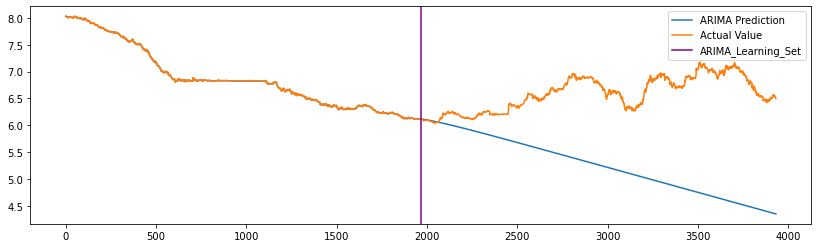

In [42]:
# draw predict figure
plt.figure(figsize=(14, 4))
plt.plot(preds_pd,label="ARIMA Prediction")
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.plot(data_raw.iloc[1:]["Price"],label="Actual Value")
plt.axvline(x=train_len,label="ARIMA_Learning_Set",color='purple')
plt.legend()
#plt.savefig('./2006—50%ARIMA.jpg')
plt.show()

In [43]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ARIMA_Result['raw'] = data_raw['Price']
ARIMA_Result['predicted'] = preds_pd
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
ARIMA_Result

,raw,predicted,residuals
0,8.0315,8.030570,0.000930
1,8.0280,8.027258,0.000742
2,8.0288,8.027863,0.000937
3,8.0283,8.027219,0.001081
4,8.0299,8.028806,0.001094
...,...,...,...
3927,6.5292,4.353596,2.175604
3928,6.5220,4.352666,2.169334
3929,6.5203,4.351736,2.168564
3930,6.5085,4.350806,2.157694


In [44]:
LSTM_data = ARIMA_Result
ARIMA_close_prices = LSTM_data['residuals'][train_len:].values.astype(float)


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [45]:
# %% split data for training and testing
def split_data(stock, lookback, test_percentage):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(test_percentage*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test,train_set_size]

In [46]:
Price_scaler = MinMaxScaler(feature_range=(-1, 1))
ARIMA_close_prices = Price_scaler.fit_transform(ARIMA_close_prices.reshape(-1,1))

In [47]:
lookback = 50  # choose sequence length for history value
x_train, y_train, x_test, y_test,train_set_size = split_data(ARIMA_close_prices, lookback, 0.3)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1341, 49, 1)
y_train.shape =  (1341, 1)
x_test.shape =  (575, 49, 1)
y_test.shape =  (575, 1)


In [48]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [49]:
input_dim = 1
hidden_dim = 32 # hidden nums
num_layers = 2
output_dim = 1
num_epochs = 100

In [50]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [51]:

# %% train LSTM model
loss_record = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, ", MSE: ", loss.item())
    loss_record[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time() - start_time
print("Training time: {}".format(training_time))



Epoch  0 , MSE:  0.2006799578666687
Epoch  1 , MSE:  0.1903916299343109
Epoch  2 , MSE:  0.16771885752677917
Epoch  3 , MSE:  0.1413877308368683
Epoch  4 , MSE:  0.07835543155670166
Epoch  5 , MSE:  0.041135307401418686
Epoch  6 , MSE:  0.026837950572371483
Epoch  7 , MSE:  0.023587973788380623
Epoch  8 , MSE:  0.002060443162918091
Epoch  9 , MSE:  0.009494144469499588
Epoch  10 , MSE:  0.014834404923021793
Epoch  11 , MSE:  0.012486848048865795
Epoch  12 , MSE:  0.009441421367228031
Epoch  13 , MSE:  0.006077514495700598
Epoch  14 , MSE:  0.00313736405223608
Epoch  15 , MSE:  0.004431627690792084
Epoch  16 , MSE:  0.00835675373673439
Epoch  17 , MSE:  0.007059499621391296
Epoch  18 , MSE:  0.0038976010400801897
Epoch  19 , MSE:  0.0028120758943259716
Epoch  20 , MSE:  0.0028269789181649685
Epoch  21 , MSE:  0.0031272985506802797
Epoch  22 , MSE:  0.00374329905025661
Epoch  23 , MSE:  0.004215291701257229
Epoch  24 , MSE:  0.003605665173381567
Epoch  25 , MSE:  0.0021500124130398035
Ep

In [52]:
# %% prediction on test dataset
y_test_pred = model(x_test)

# inverse predictions
y_train_pred = Price_scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = Price_scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = Price_scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = Price_scaler.inverse_transform(y_test_lstm.detach().numpy())




In [53]:
predict=LSTM_data['predicted'][train_len+train_set_size+lookback:].values.astype(float)+y_test_pred.reshape(-1)

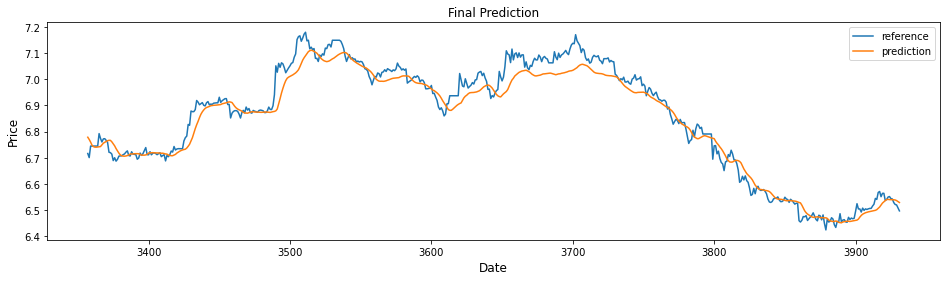

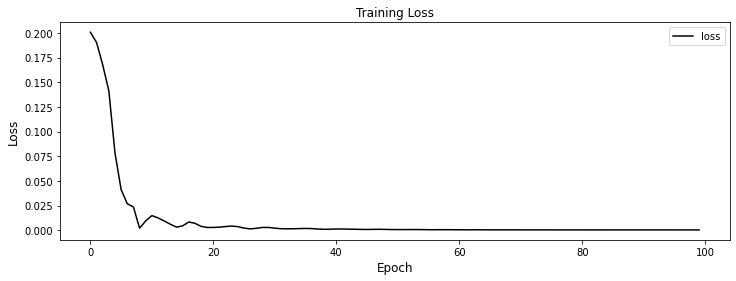

X_test MSE: 0.0018719351963954645
X_test MAE: 0.03194726827161769
X_test RMSE: 0.043265866412166815
X_test RMSLE: 0.005440380708116794
X_test RMSLE: 0.005440380708116794


In [54]:
# %% plot on training dataset
fig = plt.figure(figsize=(16, 4))

plt.plot(LSTM_data['raw'][train_len+train_set_size+lookback:],  label='reference')
plt.plot(range(train_len+train_set_size+lookback,len(LSTM_data['raw'])),predict,  label='prediction')
plt.title('Final Prediction', size=12)
plt.xlabel('Date', size=12)
plt.ylabel('Price', size=12)
plt.legend()
#plt.savefig('./2015—50%LSTM.jpg')
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.plot(loss_record, 'b', label='loss',color='black')
plt.title('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend()
#plt.savefig('./2015—50%LSTM-loss.jpg')
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

mse = mean_squared_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict)     
mae = mean_absolute_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict)
rmse = np.sqrt(mse)
rmsle = np.sqrt(mean_squared_log_error(LSTM_data['raw'][train_len+train_set_size+lookback:], predict))


print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RMSLE: {rmsle}')
print(f'X_test RMSLE: {rmsle}')

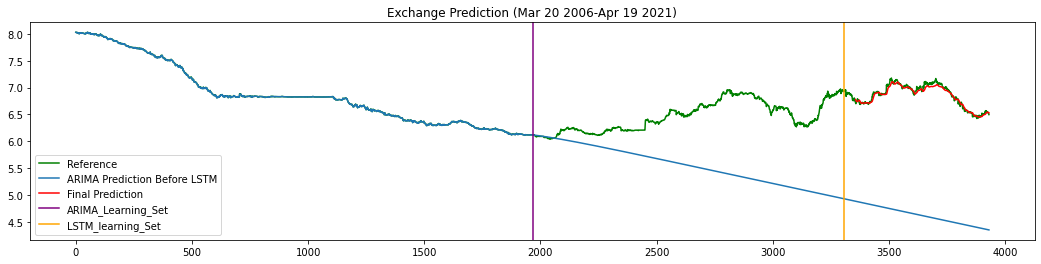

In [55]:
# draw predict figure

plt.figure(figsize=(18, 4))
plt.plot(LSTM_data['raw'],label="Reference",color='green')
plt.plot(preds_pd,label="ARIMA Prediction Before LSTM")
plt.plot(range(train_len+train_set_size+lookback,len(LSTM_data['raw'])),predict,color='red', label='Final Prediction')
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.axvline(x=train_len,color='purple',label="ARIMA_Learning_Set")
plt.axvline(x=train_len+train_set_size, color='orange',label="LSTM_learning_Set")
plt.title('Exchange Prediction (Mar 20 2006-Apr 19 2021)', size=12)
plt.legend()
plt.savefig('./2015—30%all.jpg')
plt.show()